In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Read CSV and Clean

In [2]:
df = pd.read_csv("exoplanet_data.csv")
# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')
# # Drop the null rows
df = df.dropna()
df.head()
df.koi_disposition.value_counts()

FALSE POSITIVE    3504
CONFIRMED         1800
CANDIDATE         1687
Name: koi_disposition, dtype: int64

In [3]:
df.koi_disposition[df.koi_disposition == 'CANDIDATE'] = 1
df.koi_disposition[df.koi_disposition == 'FALSE POSITIVE'] = 0
df.koi_disposition[df.koi_disposition == 'CONFIRMED'] = 0
df2 = df.koi_disposition.astype(float)
df2
target_names  = ["Candidate", "Not"]

/Users/pest/anaconda3/envs/PythonData=3.6/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/pest/anaconda3/envs/PythonData=3.6/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/pest/anaconda3/envs/PythonData=3.6/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

In [4]:
data = df.drop("koi_disposition", axis=1)
target = df2.values.reshape(-1,1)
print(data.shape, target.shape)
target.dtype

(6991, 40) (6991, 1)


dtype('float64')

### Feature Selection (using Random Forest Ensemble)

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [6]:
model = RandomForestClassifier(n_estimators=100)
model.fit(data, target)

/Users/pest/anaconda3/envs/PythonData=3.6/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [7]:
importances = model.feature_importances_

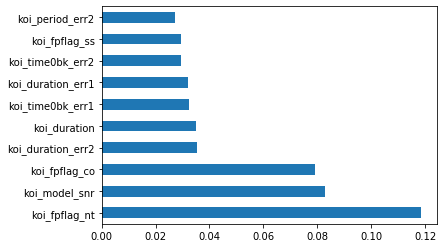

koi_fpflag_nt        0.118345
koi_model_snr        0.083013
koi_fpflag_co        0.079001
koi_duration_err2    0.035407
koi_duration         0.034853
koi_time0bk_err1     0.032328
koi_duration_err1    0.032199
koi_time0bk_err2     0.029465
koi_fpflag_ss        0.029285
koi_period_err2      0.027126
dtype: float64


In [8]:
selected_features = pd.Series(model.feature_importances_, data.columns)
selected_features.nlargest(10).plot(kind='barh')
plt.show()
print(selected_features.nlargest(10))

In [10]:
selected_data = data[['koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_nt', 'koi_model_snr','koi_time0bk_err1', 'koi_time0bk_err2', 'koi_duration_err1','koi_duration_err2','koi_duration','koi_period_err2']].copy()

### Create a Train - Test Split (with the selected features)

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(selected_data, target, random_state=1)
X_train.head()

,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_nt,koi_model_snr,koi_time0bk_err1,koi_time0bk_err2,koi_duration_err1,koi_duration_err2,koi_duration,koi_period_err2
3563,0,0,0,11.7,0.004110,-0.004110,0.1430,-0.1430,1.8720,-5.470000e-05
4099,0,0,0,18.0,0.004460,-0.004460,0.1530,-0.1530,3.3900,-1.365000e-04
5460,0,0,0,476.0,0.000096,-0.000096,0.0152,-0.0152,1.5795,-1.230000e-07
1091,0,0,0,34.7,0.005290,-0.005290,0.1650,-0.1650,10.3280,-1.461000e-03
5999,0,0,0,8.7,0.028600,-0.028600,0.9390,-0.9390,10.2940,-3.181000e-03


### Pre-processing (using MinMaxScaler)

In [14]:
from sklearn.preprocessing import MinMaxScaler
X_minmax = MinMaxScaler().fit(X_train)
y_minmax = MinMaxScaler().fit(y_train)

X_train_minmax = X_minmax.transform(X_train)
X_test_minmax = X_minmax.transform(X_test)
y_train_minmax = y_minmax.transform(y_train)
y_test_minmax = y_minmax.transform(y_test)

### Train the Model

In [18]:
model.fit(X_train_minmax, y_train_minmax)
predictions = model.predict(X_test_minmax)

/Users/pest/anaconda3/envs/PythonData=3.6/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


In [19]:
print(f"Training Data Score: {model.score(X_train_minmax, y_train_minmax)}")
print(f"Testing Data Score: {model.score(X_test_minmax, y_test_minmax)}")

Training Data Score: 1.0
Testing Data Score: 0.8838672768878718


### Classification Report

In [26]:
from sklearn.metrics import classification_report
predictions = model.predict(X_test_minmax)
print(classification_report(y_test_minmax, predictions,
                            target_names=target_names))

              precision    recall  f1-score   support

   Candidate       0.91      0.94      0.93      1344
         Not       0.78      0.69      0.73       404

    accuracy                           0.88      1748
   macro avg       0.85      0.81      0.83      1748
weighted avg       0.88      0.88      0.88      1748



### Save Model

In [27]:
import joblib